## Goal: Develop a model to predict whether a molecule will be active/inactive towards CCR5 inhibition

## Evaluate 3 different classification algorithms:
    1) Gradient Boosted Tree
    2) Support Vector Classifier
    3) Artificial Neural Network

Evaluation metrics include: 
    ROC curve along with area under curve; 
    precision, recall, and f1-score (confusion matrix, classification report)

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem, PandasTools, rdFingerprintGenerator
from chembl_webresource_client.new_client import new_client
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
chembl_id = 'CHEMBL274' #ccr5 chembl id

In [7]:
activities_api = new_client.activity
activities = activities_api.filter(target_chembl_id=chembl_id,type='IC50',relation='=',assay_type='B').only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism")

In [8]:
activities_df = pd.DataFrame.from_records(activities)

In [9]:
activities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,75508,CHEMBL654653,Binding affinity against C-C chemokine recepto...,B,CHEMBL105460,=,nM,335.0,CHEMBL274,Homo sapiens,IC50,nM,335.0
1,75508,CHEMBL654653,Binding affinity against C-C chemokine recepto...,B,CHEMBL105460,=,nM,335.0,CHEMBL274,Homo sapiens,IC50,nM,335.0
2,75509,CHEMBL654653,Binding affinity against C-C chemokine recepto...,B,CHEMBL105606,=,nM,28.0,CHEMBL274,Homo sapiens,IC50,nM,28.0
3,75510,CHEMBL654653,Binding affinity against C-C chemokine recepto...,B,CHEMBL105570,=,nM,10.0,CHEMBL274,Homo sapiens,IC50,nM,10.0
4,76739,CHEMBL873385,Binding affinity against human CCR5 receptor s...,B,CHEMBL83338,=,nM,35.0,CHEMBL274,Homo sapiens,IC50,nM,35.0


In [10]:
act_df = activities_df.drop(['assay_description','assay_type','relation','units','value'],axis=1)

In [11]:
act_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_id         1757 non-null   int64 
 1   assay_chembl_id     1757 non-null   object
 2   molecule_chembl_id  1757 non-null   object
 3   standard_units      1757 non-null   object
 4   standard_value      1757 non-null   object
 5   target_chembl_id    1757 non-null   object
 6   target_organism     1757 non-null   object
 7   type                1757 non-null   object
dtypes: int64(1), object(7)
memory usage: 109.9+ KB


In [12]:
act_df['standard_value'] = act_df['standard_value'].astype('float64')

In [13]:
act_df.isnull().sum() #no null values

activity_id           0
assay_chembl_id       0
molecule_chembl_id    0
standard_units        0
standard_value        0
target_chembl_id      0
target_organism       0
type                  0
dtype: int64

In [14]:
act_df['standard_units'].unique() #check units, all are in 'nM'

array(['nM'], dtype=object)

In [24]:
act_df = act_df.drop_duplicates('molecule_chembl_id',keep='first')

In [26]:
act_df = act_df.reset_index(drop=True)

In [15]:
# convert IC50 to pIC50
act_df = act_df.rename(columns={'standard_value':'IC50'})
act_df['pIC50'] = 9 - np.log10(act_df['IC50'])

In [17]:
act_df = act_df[['molecule_chembl_id','pIC50']] #only need chembl_id and pIC50 columns now

In [19]:
#use chembl_ids to retrieve molecule structures from Chembl
chembl_ids = act_df['molecule_chembl_id'].to_list()
molecules = new_client.molecule
mols = molecules.filter(molecule_chembl_id__in=chembl_ids).only('molecule_chembl_id','molecule_structures')
mols = list(mols)

In [20]:
molecules = pd.DataFrame.from_records(mols)

In [21]:
molecules['molecule_structures']

0       {'canonical_smiles': 'CC(C)(C)c1ccc(C(O)CCCN2C...
1       {'canonical_smiles': 'O=C(O)[C@@H](CC1CCC1)N1C...
2       {'canonical_smiles': 'COP(=O)(CCC1CCN(C[C@H]2C...
3       {'canonical_smiles': 'O=C(O)[C@@H](C1CCCCC1)N1...
4       {'canonical_smiles': 'O=C(O)[C@@H](CC1CCC1)N1C...
                              ...                        
1480    {'canonical_smiles': 'Nc1nc2[nH]c(C3CC3)c(Cc3c...
1481    {'canonical_smiles': 'CC(=O)C1=C(O)C(=O)N(c2cc...
1482    {'canonical_smiles': 'CC(C)c1[nH]c2nc(N)nn2c(=...
1483    {'canonical_smiles': 'CC(C)c1[nH]c2nc(N)nn2c(=...
1484    {'canonical_smiles': 'CC(C)c1[nH]c2nc(N)nn2c(=...
Name: molecule_structures, Length: 1485, dtype: object

In [22]:
molecules['smiles'] = molecules['molecule_structures'].apply(lambda x: x.get('canonical_smiles',np.nan))
molecules = molecules.drop('molecule_structures',axis=1)

In [23]:
molecules = pd.merge(molecules,act_df[['molecule_chembl_id','pIC50']],on='molecule_chembl_id')

In [24]:
molecules

,molecule_chembl_id,smiles,pIC50
0,CHEMBL17157,CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...,5.957424
1,CHEMBL20345,O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCSc3ccc(...,10.000000
2,CHEMBL20345,O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCSc3ccc(...,10.000000
3,CHEMBL20818,COP(=O)(CCC1CCN(C[C@H]2CN([C@H](CC3CC3)C(=O)O)...,7.721246
4,CHEMBL280344,O=C(O)[C@@H](C1CCCCC1)N1C[C@H](CN2CCC(CCS(=O)(...,8.958607
...,...,...,...
1752,CHEMBL4517518,Nc1nc2[nH]c(C3CC3)c(Cc3cccc(Cl)c3)c(=O)n2n1,3.243364
1753,CHEMBL4519152,CC(=O)C1=C(O)C(=O)N(c2ccc(Cl)cc2F)[C@@H]1C1CCCCC1,6.153045
1754,CHEMBL4531005,CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1cccc(Cl)c1Cl,4.075721
1755,CHEMBL4544504,CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1ccc(Cl)c(Br)c1,3.939302


In [173]:
class FingerPrinter(BaseEstimator,TransformerMixin):
    
    def __init__(self,gen_method='morgan',radius=3):
        self.radius = radius
        self.gen = self.get_gen_method(gen_method)
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        mols = [Chem.MolFromSmiles(row.smiles) for _,row in X.iterrows()]
        #gen = rdFingerprintGenerator.GetMorganGenerator(self.radius)
        fps = [np.array(self.gen.GetFingerprint(mol)) for mol in mols]
        return fps
    
    def get_gen_method(self,gen_method):
        if gen_method.lower() == 'morgan':
            return rdFingerprintGenerator.GetMorganGenerator(self.radius)
        elif gen_method.lower() == 'atom_pair':
            return rdFingerprintGenerator.GetAtomPairGenerator()
        elif gen_method.lower() == 'rdfp':
            return rdFingerprintGenerator.GetRDKitFPGenerator()
        else:
            print('Invalid method selected. None returned')
            return None

In [174]:
fpr = FingerPrinter()
molecules['fp'] = fpr.fit_transform(molecules)

In [175]:
molecules['active'] = (molecules['pIC50']>6.3).astype('int32')
molecules

,molecule_chembl_id,smiles,pIC50,fp,active
0,CHEMBL17157,CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...,5.957424,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,CHEMBL20345,O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCSc3ccc(...,10.000000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
2,CHEMBL20345,O=C(O)[C@@H](CC1CCC1)N1C[C@H](CN2CCC(CCSc3ccc(...,10.000000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
3,CHEMBL20818,COP(=O)(CCC1CCN(C[C@H]2CN([C@H](CC3CC3)C(=O)O)...,7.721246,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,CHEMBL280344,O=C(O)[C@@H](C1CCCCC1)N1C[C@H](CN2CCC(CCS(=O)(...,8.958607,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...
1752,CHEMBL4517518,Nc1nc2[nH]c(C3CC3)c(Cc3cccc(Cl)c3)c(=O)n2n1,3.243364,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1753,CHEMBL4519152,CC(=O)C1=C(O)C(=O)N(c2ccc(Cl)cc2F)[C@@H]1C1CCCCC1,6.153045,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1754,CHEMBL4531005,CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1cccc(Cl)c1Cl,4.075721,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1755,CHEMBL4544504,CC(C)c1[nH]c2nc(N)nn2c(=O)c1Cc1ccc(Cl)c(Br)c1,3.939302,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


<AxesSubplot:xlabel='active', ylabel='count'>

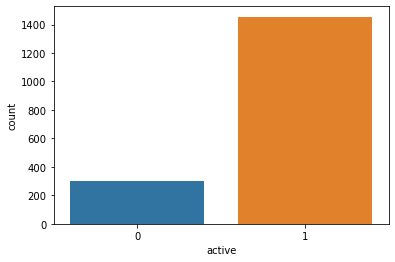

In [41]:
sns.countplot(data=molecules,x='active') 
#imbalanced class distribution - will need to account for this with certain ML algorithms (i.e. SVC, ANN)

In [143]:
X = molecules['fp'].to_list()
y = molecules['active'].values
X = np.array(X)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [145]:
gbc = GradientBoostingClassifier()
params = {'n_estimators':[10,25,50,100,200],'max_depth':[3,4,5,6]}
grid_clf = GridSearchCV(estimator=gbc, param_grid=params, cv=10)
grid_clf.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'n_estimators': [10, 25, 50, 100, 200]})

In [146]:
grid_clf.best_params_

{'max_depth': 5, 'n_estimators': 50}

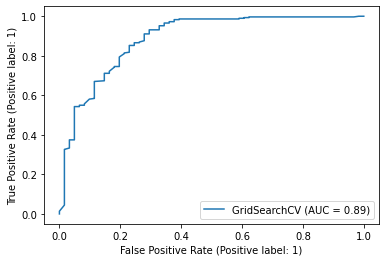

In [147]:
plot_roc_curve(grid_clf,X_test,y_test)

In [148]:
y_hat = grid_clf.predict(X_test)
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.80      0.64      0.71        61
           1       0.93      0.97      0.95       291

    accuracy                           0.91       352
   macro avg       0.86      0.80      0.83       352
weighted avg       0.90      0.91      0.91       352



In [149]:
confusion_matrix(y_test,y_hat)

array([[ 39,  22],
       [ 10, 281]], dtype=int64)

Support Vector Classifier

In [138]:
svc = SVC(class_weight='balanced',probability=True)
params = {'kernel':['linear','rbf'],'C':[0.01,0.1,1,10]}
grid_svc = GridSearchCV(estimator=svc,param_grid=params,cv=10)
grid_svc.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']})

In [139]:
grid_svc.best_params_

{'C': 10, 'kernel': 'rbf'}

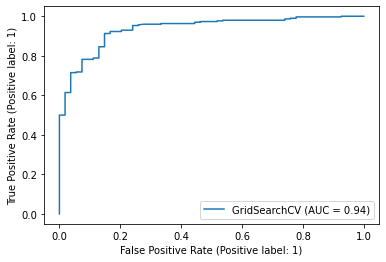

In [140]:
plot_roc_curve(grid_svc,X_test,y_test)

In [141]:
y_hat = grid_svc.predict(X_test)
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75        54
           1       0.96      0.95      0.95       298

    accuracy                           0.92       352
   macro avg       0.84      0.85      0.85       352
weighted avg       0.92      0.92      0.92       352



In [142]:
confusion_matrix(y_test,y_hat)

array([[ 41,  13],
       [ 15, 283]], dtype=int64)

Artificial Neural Network

In [115]:
X = molecules['fp'].to_list()
y = molecules['active'].values
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [68]:
pos = np.sum(y==1)
neg = np.sum(y==0)
total = len(y)
wgt_0 = (1/neg) * (total/2.0)
wgt_1 = (1/pos) * (total/2.0)
class_weight = {0:wgt_0, 1:wgt_1}
print(f'#pos = {pos}\n#neg = {neg}\ntotal = {total}')

#pos = 1455
#neg = 302
total = 1757


In [160]:
early_stop = EarlyStopping(monitor='val_loss', patience=25, mode='min')

In [161]:
model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')

In [162]:
model.fit(x=X_train,y=y_train,batch_size=256,epochs=500,callbacks=early_stop,class_weight=class_weight,
         validation_data=(X_test,y_test))

Epoch 1/500
6/6 [==============================] - 0s 27ms/step - loss: 0.6570 - val_loss: 0.5316
Epoch 2/500
6/6 [==============================] - 0s 12ms/step - loss: 0.5642 - val_loss: 0.4335
Epoch 3/500
6/6 [==============================] - 0s 14ms/step - loss: 0.4545 - val_loss: 0.4228
Epoch 4/500
6/6 [==============================] - 0s 14ms/step - loss: 0.3659 - val_loss: 0.3695
Epoch 5/500
6/6 [==============================] - 0s 14ms/step - loss: 0.3155 - val_loss: 0.3799
Epoch 6/500
6/6 [==============================] - 0s 11ms/step - loss: 0.2588 - val_loss: 0.3116
Epoch 7/500
6/6 [==============================] - 0s 14ms/step - loss: 0.2249 - val_loss: 0.3103
Epoch 8/500
6/6 [==============================] - 0s 14ms/step - loss: 0.1791 - val_loss: 0.3060
Epoch 9/500
6/6 [==============================] - 0s 14ms/step - loss: 0.1706 - val_loss: 0.3258
Epoch 10/500
6/6 [==============================] - 0s 12ms/step - loss: 0.1581 - val_loss: 0.3459
Epoch 11/500
6/6 [=

<AxesSubplot:>

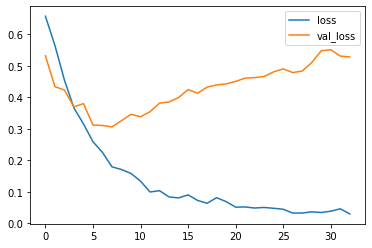

In [163]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [164]:
y_hat = (model.predict(X_test)>0.5).astype('int32')
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70        61
           1       0.94      0.93      0.94       291

    accuracy                           0.89       352
   macro avg       0.82      0.82      0.82       352
weighted avg       0.90      0.89      0.90       352



In [165]:
confusion_matrix(y_test,y_hat)

array([[ 43,  18],
       [ 19, 272]], dtype=int64)

In [166]:
from sklearn.metrics import roc_curve, roc_auc_score

In [167]:
y_score = model.predict(X_test)

In [168]:
fpr, tpr, th = roc_curve(y_test,y_score)

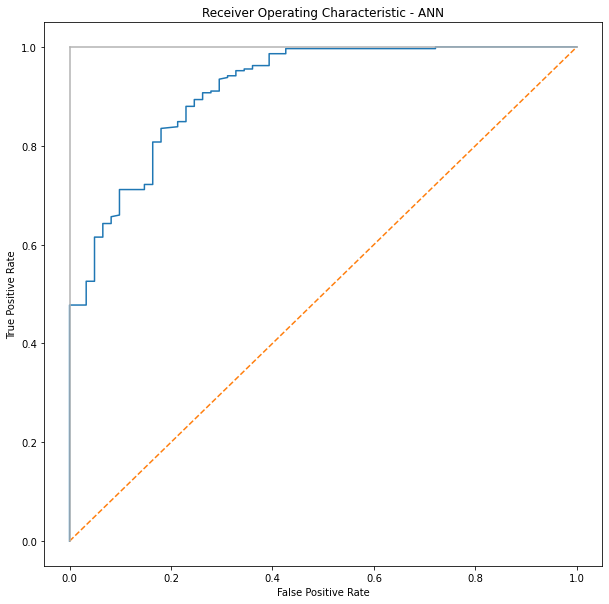

In [169]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - ANN')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [170]:
print('AUC: ',roc_auc_score(y_test,y_score))

AUC:  0.9146526956227818


# Conclusions
The SVC showed the best predictive performance with an AUC of 0.94 and Accuracy of 0.92. 
Due to the imblanced class distribution (many more 'active' samples compared to 'inactive') accuracy alone is not a very good metric to measure classification performance. Simply classifying all samples as active would lead a decent accuracy score. Therefore, a better metric is the lowest number of false positives and false negatives. The support vector classifier had the lowest number of false positives at 13/352 compared to 22/352 and 18/352 for the Gradient Boosted Tree and Artificial Neural Network, respectively. 